In [2]:
#using Pkg
#Pkg.add("Shuffle")

using DataFrames, CSV, JuMP, Gurobi, Metrics, Plots, StatsBase, Shuffle, Random

In [3]:
# load data
train_valid = CSV.read("train_valid.csv", DataFrame)
test = CSV.read("test.csv", DataFrame);

In [4]:
# define target and features
target = "value_eur"
# features = all columns that are Not(target)
features = setdiff(names(train_valid), [target]);

function get_features(df)
    # get features from dataframe
    return df[:, features]
end

function get_target(df)
    # get target from dataframe
    return df[:, target]
end

X_train_valid = get_features(train_valid)
y_train_valid = get_target(train_valid)
X_test = get_features(test)
y_test = get_target(test);

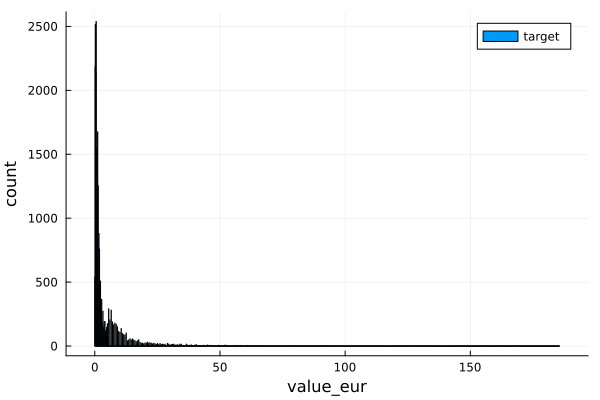

In [5]:
# plot target
histogram(get_target(train_valid), label="target", xlabel="value_eur", ylabel="count")

## Define functions that will be used across models

In [62]:
function compute_results(y_pred, y_true)
    
    # compute the results
    mae = Metrics.mae(y_pred, y_true)
    mape = sum(abs.(y_pred - y_true) ./ y_true) / length(y_true)
    mse = Metrics.mse(y_pred, y_true)
    rmse = sqrt(mse)
    r2 = Metrics.r2_score(y_pred, y_true)

    # store the results in a DataFrame
    results = DataFrame(
        MAE = [mae],
        MAPE = [mape],
        MSE = [mse],
        RMSE = [rmse],
        R2 = [r2]
    )

    return results
end

function plot_results(y_pred, y_true)
    
    # plot both distributions
    # set plot dimensions
    plot_size = (800, 400)
    
    histogram(y_pred, label = "pred", color = "red", seriesalpha = 0.5)
    display(histogram!(y_true, label = "test", color = "blue", seriesalpha = 0.5))

    # plot (scatter) the predictions vs the true values
    #display(scatter(y_pred, y_true, label = "pred vs test", xlabel = "pred", ylabel = "test", size = plot_size))
end 

plot_results (generic function with 1 method)

## Holistic regression

In [7]:
function pairwise_correlation(data, rho)

    cor_matrix = cor(Matrix(data))

    # we know that the matrix is symmetrix
    # no need to include the correlation between one variable and itself, of course it is 1
    
    p = size(cor_matrix)[1]

    # list to record the variables with which X[i] is correlated
    correlated = []

    for i = 1:(p-1)     
        for j = (i+1):p
            if abs(cor_matrix[i, j]) > rho
                push!(correlated, (i, j))
            end
        end
    end

    return correlated
end

pairwise_correlation (generic function with 1 method)

In [8]:
function transform_data(data)
    
    n, p = size(data)
    epsilon = 1

    new = []

    for j = 1:p
        push!(new, data[:, j])
        push!(new, sqrt.(abs.(data[:, j])))
        push!(new, log.(abs.(data[:, j]) .+ epsilon))
    end

    return hcat(new...)
end

transform_data (generic function with 1 method)

In [43]:
function HolisticRegression(X, y, lambda, k, rho)

    # define the model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)

    # add time limit
    set_optimizer_attribute(model, "TimeLimit", 120)

    # PARAMETERS

    n, p = size(X)

    M = 50

    # call function pairwise_correlation to define HC(X)
    HC = pairwise_correlation(X, rho)
    # define set Tj, because we want to keep at most one transformation
    print(1)
    T = []
    for j = 1:Int(p/3) # this applies to the original p
        push!(T, X[:, 3*(j-1)+1 : 3*(j-1)+3])
    end

    # VARIABLES

    @variable(model, beta[1:p])
    @variable(model, t)
    @variable(model, r)
    @variable(model, q[1:p])
    @variable(model, z[1:p], binary = true) # binary variable

    # OBJECTIVE FUNCTION

    @objective(model, Min, t + lambda * r)

    # CONSTRAINTS

    @constraint(model, t >= sum((y[i]-sum(X[i,j]*beta[j] for j=1:p))^2 for i=1:n)) # to rewrite objective function
    @constraint(model, r >= sum(q[j] for j=1:p)) # to rewrite objective function
    @constraint(model, [j=1:p], q[j] >= beta[j]) # to rewrite objective function
    @constraint(model, [j=1:p], q[j] >= -beta[j]) # to rewrite objective function

    @constraint(model, [i=1:p], beta[i]<=M*z[i]) # sparsity
    @constraint(model, [i=1:p], beta[i]>=-M*z[i]) # sparsity
    @constraint(model, sum(z[i] for i=1:p) <= k) # sparsity

    # pairwise collinearity
    for (i,j) in HC
        @constraint(model, z[i] + z[j] <= 1)
    end
    
    # nonlinear transformation
    @constraint(model, [j=1:Int(p/3)], sum(z[i] for i = 3*(j-1)+1 : 3*(j-1)+3) <= 1)

    # group sparsity

    # significance

    # multicollinear relations

    # OPTIMIZE

    optimize!(model)

    return objective_value(model), value.(beta)

end

HolisticRegression (generic function with 1 method)

In [44]:
function Holistic_model(train_valid, test)

    X_train = transform_data(get_features(train_valid))
    y_train = get_target(train_valid)

    X_test = transform_data(get_features(test))
    y_test = get_target(test)

    p_total = size(X_train)[2] / 3

    # initialize best model
    best_obj, best_beta = HolisticRegression(X_train, y_train, 0, p_total, 0.5)
    best_rho = 0.5
    best_k = p_total
    best_lambda = 0

    # run HolisticRegression for different values of rho, k and lambda
    rho_list = [0.7, 0.9]
    k_list = [8, 15]
    lambda_list = [0.1, 0.5]

    for rho in rho_list
        for k in k_list
            for lambda in lambda_list
                obj, beta = HolisticRegression(X_train, y_train, lambda, k, rho)
                if obj < best_obj
                    best_obj = obj
                    best_beta = beta
                    best_rho = rho
                    best_k = k
                    best_lambda = lambda
                end
            end
        end
    end

    println("Best model: rho = ", best_rho, ", k = ", best_k, ", lambda = ", best_lambda)

    # make predictions on both train and test
    y_pred_train = X_train * best_beta
    y_pred_test = X_test * best_beta

    # there should be no negative predictions
    y_pred_train[y_pred_train .< 0] .= 0
    y_pred_test[y_pred_test .< 0] .= 0

    # compute the results on both train and test
    results_train = compute_results(y_pred_train, y_train)
    results_test = compute_results(y_pred_test, y_test)

    # concatenate the results
    results = vcat(results_train, results_test)

    # plot the results
    plot_results(y_pred_test, y_test)

    # print the results
    display(results)

    # return the best model
    return best_beta
end

Holistic_model (generic function with 1 method)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
Set parameter TimeLimit to value 120
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
Set parameter TimeLimit to value 120
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
Set parameter TimeLimit to value 120
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
Set parameter TimeLimit to value 120
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
Set parameter TimeLimit to value 120
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
Set parameter TimeLimit to value 120
Set parameter Us

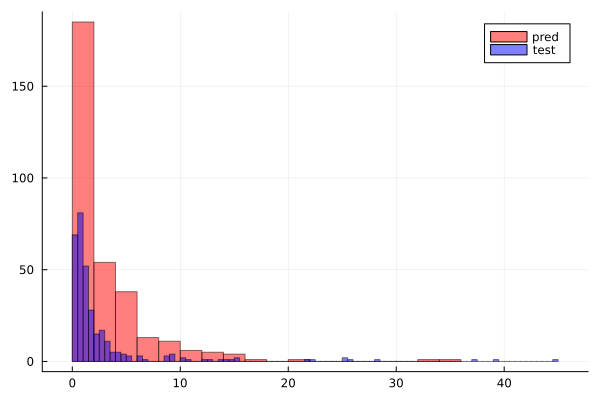

Row,MAE,MSE,RMSE,R2
,Float64,Float64,Float64,Float64
1,1.43348,10.0826,3.17531,0.807406
2,1.49625,7.36405,2.71368,0.748961


177-element Vector{Float64}:
   0.4127738273593069
   0.0
   0.0
   0.0
   0.0
 -15.063678919875528
   0.00015180940982257449
   0.0
   0.0
   0.0
  -4.519013082130225
   0.0
   0.0
   ⋮
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

In [49]:
# only use a frac of the data, with similar distribution of the target
frac = 0.02
Random.seed!(0)
sample_train_valid = train_valid[Shuffle.shuffle(1:nrow(train_valid)), :][1:floor(Int, frac*nrow(train_valid)), :]
sample_test = test[Shuffle.shuffle(1:nrow(test)), :][1:floor(Int, frac*nrow(test)), :]

# first try with one single HolisticRegression
#HolReg_obj, HolReg_beta = HolisticRegression(transform_data(get_features(sample_train_valid)), get_target(sample_train_valid), 0.5, 10, 0.7)

# run the model
HolReg_beta = Holistic_model(sample_train_valid, sample_test)

In [50]:
# max abs value of HolReg_beta
maximum(abs.(HolReg_beta))

21.975163270965236

Row,MAE,MAPE,MSE,RMSE,R2
,Float64,Float64,Float64,Float64,Float64
1,1.58566,1.36962,14.056,3.74913,0.711831
2,1.73422,1.14741,19.7447,4.44351,0.679304


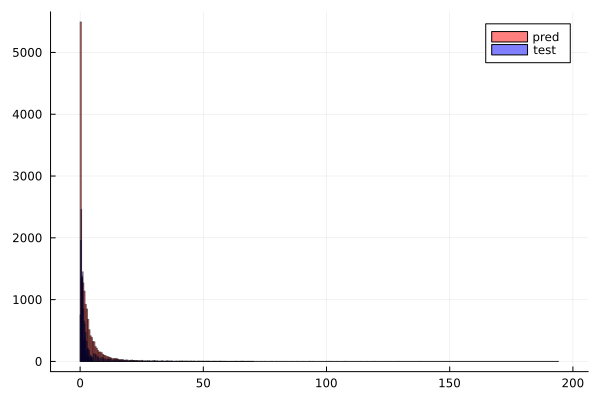

In [63]:
# make predictions on the train set and the test set
HolReg_pred_train_valid = transform_data(get_features(train_valid)) * HolReg_beta
HolReg_pred_test = transform_data(get_features(test)) * HolReg_beta

# there should be no negative predictions
HolReg_pred_train_valid[HolReg_pred_train_valid .< 0] .= 0
HolReg_pred_test[HolReg_pred_test .< 0] .= 0

# compute the results on the train set and the test set
HolReg_results_train_valid = compute_results(HolReg_pred_train_valid, get_target(train_valid))
HolReg_results_test = compute_results(HolReg_pred_test, get_target(test))

# concatenate the results
HolReg_results = vcat(HolReg_results_train_valid, HolReg_results_test)

# print the results
display(HolReg_results)

# plot the results
plot_results(HolReg_pred_test, get_target(test))

In [52]:
# create a list of feature_names: 3 columns for each feature ("normal", "sqrt", "log")
initial_feature_names = names(get_features(train_valid))

feature_names = []

for i = 1:length(initial_feature_names)
    push!(feature_names, initial_feature_names[i] * "_normal")
    push!(feature_names, initial_feature_names[i] * "_sqrt")
    push!(feature_names, initial_feature_names[i] * "_log")
end

# create a dataframe with the results
HolReg_results_df = DataFrame(feature_names = feature_names, beta = HolReg_beta)

# only keep the features with non-zero coefficients
HolReg_results_df = HolReg_results_df[HolReg_results_df.beta .> 1e-6, :]

# sort the dataframe by the absolute value of the coefficients
sort!(HolReg_results_df, :beta, rev = true)

# print the results
display(HolReg_results_df)



Row,feature_names,beta
,Any,Float64
1,international_reputation_sqrt,3.56939
2,passing_normal,1.20815
3,overall_normal,0.412774
4,club_contract_valid_until_normal,0.0911492
5,attacking_volleys_normal,0.0586466
6,wage_eur_normal,0.000151809


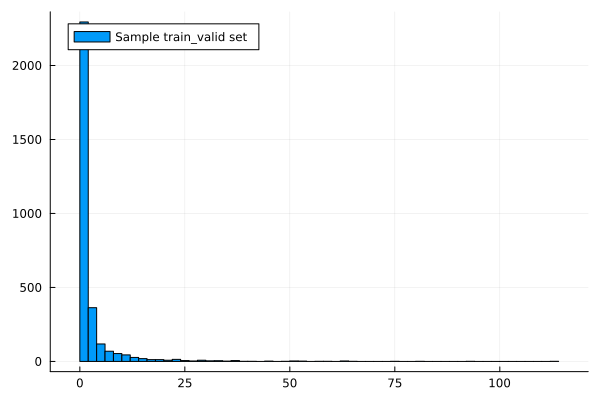

In [40]:
# prediction histogram
#histogram(HolReg_pred_test, bins = 100, label = "Holistic Regression", legend = :topleft)

# test set histogram
#histogram(get_target(test), bins = 100, label = "Test set", legend = :topleft)

# train_valid set histogram
#histogram(get_target(train_valid), bins = 100, label = "Train_valid set", legend = :topleft)

# sample train_valid set histogram
#histogram(get_target(sample_train_valid), bins = 100, label = "Sample train_valid set", legend = :topleft)

# sample test set histogram
#histogram(get_target(sample_test), bins = 100, label = "Sample test set", legend = :topleft)

## ORT (Optimal Regression Trees)

In [53]:
# define ranges for the hyperparameters
max_depth = [3, 4, 5]
minbucket = [2, 5, 10]
;

In [54]:
function ORT_model(train_valid, test)

    # define the model  
    model_oct = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
    )    

    # define the grid
    grid_oct = IAI.GridSearch(
        model_oct,
        max_depth = max_depth,
        minbucket = minbucket,
    )

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_oct,
     get_features(train_valid), 
     get_target(train_valid), 
     #train_valid[:, target],
     validation_criterion = :mse, n_folds=5)

    # make predictions on both train and test
    y_pred_train = IAI.predict(grid_oct, get_features(train_valid))
    y_pred_test = IAI.predict(grid_oct, get_features(test))

    # compute the results on both train and test
    results_train = compute_results(y_pred_train, get_target(train_valid))
    results_test = compute_results(y_pred_test, get_target(test))

    # concatenate the results
    results = vcat(results_train, results_test)

    # plot the results
    plot_results(y_pred_test, get_target(test))

    # print the results
    display(results)

    # return the best model
    return IAI.get_learner(grid_oct)
end

ORT_model (generic function with 1 method)

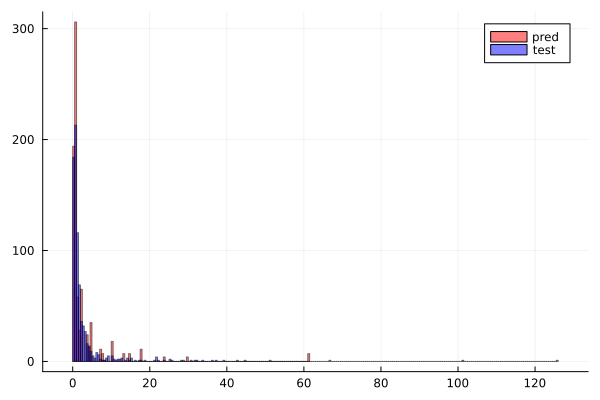

Row,MAE,MSE,RMSE,R2
,Float64,Float64,Float64,Float64
1,0.711867,3.74779,1.93592,0.91717
2,1.10827,15.625,3.95284,0.762892


In [58]:
# only use 1% of the data, with similar distribution of the target
frac = 0.05
Random.seed!(0)
sample_train_valid = train_valid[Shuffle.shuffle(1:nrow(train_valid)), :][1:floor(Int, frac*nrow(train_valid)), :]
sample_test = test[Shuffle.shuffle(1:nrow(test)), :][1:floor(Int, frac*nrow(test)), :]

# run the model
ORT_Reg = ORT_model(sample_train_valid, sample_test)

Row,MAE,MAPE,MSE,RMSE,R2
,Float64,Float64,Float64,Float64,Float64
1,0.960019,0.552117,10.0236,3.16601,0.794501
2,1.03215,0.460143,13.7974,3.71449,0.775901


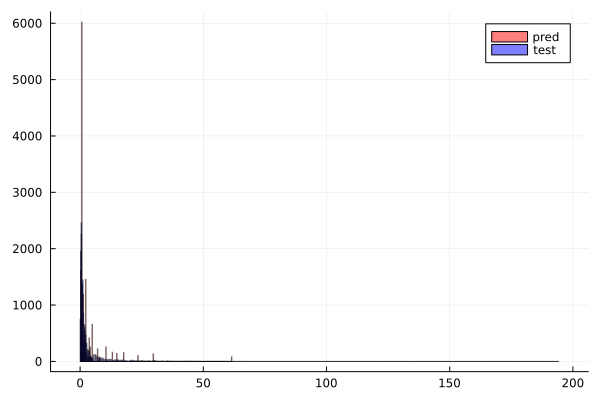

6297804

In [64]:
# make predictions on the train set and the test set
ORT_Reg_pred_train_valid = IAI.predict(ORT_Reg, get_features(train_valid))
ORT_Reg_pred_test = IAI.predict(ORT_Reg, get_features(test))

# compute the results on the train set and the test set
ORT_Reg_results_train_valid = compute_results(ORT_Reg_pred_train_valid, get_target(train_valid))
ORT_Reg_results_test = compute_results(ORT_Reg_pred_test, get_target(test))

# concatenate the results
ORT_Reg_results = vcat(ORT_Reg_results_train_valid, ORT_Reg_results_test)

# print the results
display(ORT_Reg_results)

# plot the results
plot_results(ORT_Reg_pred_test, get_target(test))

# write_json the model
IAI.write_json("ORT_Reg.json", ORT_Reg)

## ORT-H (Optimal Regression Trees with Hyperplane Splitting)

In [11]:
# define ranges for the hyperparameters
max_depth = [3, 4]
minbucket = [2, 5]
;

In [12]:
function ORTH_model(train_valid, test)

    println("Training model...")

    # define the model  
    model_octh = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
        hyperplane_config= (sparsity=:all,),
    )

    println("Fitting model...")

    # define the grid
    grid_octh = IAI.GridSearch(
        model_octh,
        max_depth = max_depth,
        minbucket = minbucket,
    )

    println("Fitting model...")

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_octh, get_features(train_valid), Array(get_target(train_valid)), validation_criterion = :mse, n_folds=5)

    println("Predicting...")

    # get the best model
    pred = IAI.predict(grid_octh, get_features(test))

    println("Computing results...")

    # compute the results
    #compute_results(pred, get_target(test))
    transform_and_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return IAI.get_learner(grid_octh)
end

ORTH_model (generic function with 1 method)

Training model...
Fitting model...
Fitting model...
Predicting...
Computing results...


Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,4.37597,81.4735,9.02626,0.338284


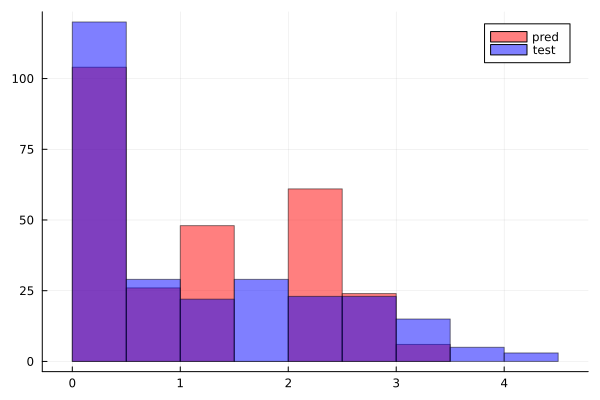

In [13]:
ORTHReg = ORTH_model(train_valid, test);

# write_json the model
IAI.write_json("ORTHReg.json", ORTHReg)

# save the predictions
ORTH_pred = IAI.predict(ORTHReg, get_features(test))
CSV.write("ORTH_pred.csv", DataFrame(pred = ORTH_pred));

In [25]:
# transform and results ORTH_pred
transform_and_results(ORTH_pred, get_target(test))

Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,4.37597,81.4735,9.02626,0.338284


Was taking such a long time to run...
Let's try again

## ORT-L (Optimal Regression Tree with Linear Regression on the leaves)

In [14]:
function ORTL_model(train_valid, test)

    # define the model  
    model_octl = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
        max_depth = 4,
        minbucket = 15,
        regression_features = All(),
    )

    println("Training model...")

    # define the grid
    grid_octl = IAI.GridSearch(
        model_octl,
        regression_lambda=[0.01, 0.05, 0.1]
    )

    println("Fitting model...")

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_octl, get_features(train_valid), Array(get_target(train_valid)), validation_criterion = :mse, n_folds=5)

    println("Predicting...")

    # get the best model
    pred = IAI.predict(grid_octl, get_features(test))

    println("Computing results...")

    # compute the results
    #compute_results(pred, get_target(test))
    transform_and_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return IAI.get_learner(grid_octl)
end

ORTL_model (generic function with 1 method)

Training model...
Fitting model...


┌ Warning: Numeric instability detected: objective value after iteration did not match the value that was expected so this change was rejected.
│ 
│ Possible causes include:
│ - using linear regression in the leaves with a small `minbucket`
│ - using `:tweedie` criterion with a large number of samples
│ 
│ If none of these apply, please let us know so we can investigate.
└ @ nothing nothing:nothing


Predicting...
Computing results...


Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,0.647486,0.69058,0.831011,0.511711


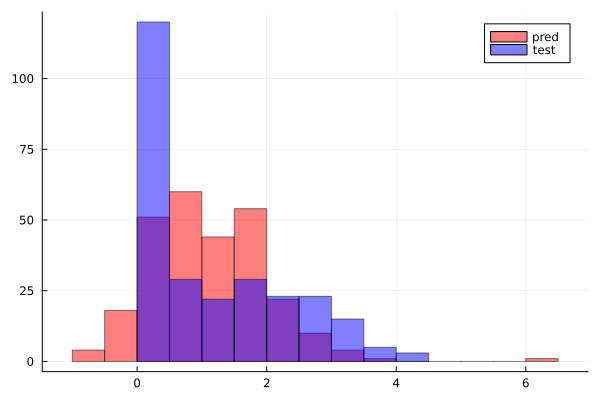

In [15]:
ORTLReg = ORTL_model(train_valid, test);

# write_json the model
IAI.write_json("ORTLReg.json", ORTLReg)

# save the predictions
ORTL_pred = IAI.predict(ORTLReg, get_features(test))
CSV.write("ORTL_pred.csv", DataFrame(pred = ORTL_pred));

In [24]:
# transfrom and results ORTL_pred
transform_and_results(ORTL_pred, get_target(test))

Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,5.84949,884.623,29.7426,-6.18479
